# Chapter 3: Classification

In this chapter the code will deal with classification techniques in ML.

## MNIST

We will start off by using the MNIST dataset which is a combination of handwritten digits written by high school students and US Postal Service. This problem tries to recognize the handwritten digits.

### Get the data 

We will use sklearn's `fetch_mldata` function to get the MNIST dataset. All of sklearn's datasets have a dictionary containing the following things.
- Descr -- Description of the data
- data -- The actual data
- target -- The target variable


In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST Original")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

### Plotting the digits

In this section we will try and plot a few of the digits to see what they actually look. The data is greyscale so it should be a black-white picture

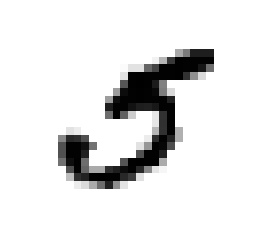

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

### Train Test split

The MNIST dataset is already split into training and testing. The first 60k are training data and the last 10k are testing data. We will get the train and test splits and also shuffle the training data so that our CV folds find all of the digits in each of the fold.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Binary Predictor

Below we will try to make the problem simple by just trying to predict whether the digit is a 5 or not. This is a binary classification problem where the classifier only tries to predict if the digit is a 5 or not.

We will then calculate the accuracy of the model and identify the issue related to accuracy as a metric of goodness of fit in classification problems

In [8]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/soutikchakraborty/venv/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [11]:
test_prediction = sgd_clf.predict(X_test)
sum(test_prediction == y_test_5)/float(len(y_test_5))

0.96030000000000004

### Custom Crossvalidation

Sometimes we will want to find out a way to implement a custom cross validation function. We can do this easily using sklearn's inbuilt functions

In [12]:
from sklearn.base import clone
from sklearn.cross_validation import StratifiedKFold

skfolds = StratifiedKFold(y_train_5, n_folds = 3, random_state=42)
fold = 0

for train_index, test_index in skfolds:
    fold = fold + 1
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_fold, y_train_fold)
    predict = clone_clf.predict(X_test_fold)
    
    n_correct = sum(predict == y_test_fold)
    print "Accuracy for fold %s = %s" %(fold, n_correct/(1.0*len(y_test_fold)))

/Users/soutikchakraborty/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy for fold 1 = 0.96655
Accuracy for fold 2 = 0.95895
Accuracy for fold 3 = 0.96785


### Cross Validation

Here we will use sklearns cross_val_score function to calculate the cross validated accuracy score of each fold

In [13]:
from sklearn.cross_validation import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train_5, cv = 5, scoring = "accuracy")

array([ 0.90009166,  0.96675   ,  0.95658333,  0.96533333,  0.96108009])

As we can see that the above prediction is at 96%. So it that a good predictor? Let us check the accuracy of a simple predictor that predicts that all of the values are not 5. 

In [14]:
not_5_predictor = False
n_correct = sum(not_5_predictor == y_test_5)
print "Accuracy is %s"%(n_correct/(1.0*len(y_test_5)))

Accuracy is 0.9108


As we can see that a simple classifier can acheive an accuracy of 91%. This makes sense as 10% of the data is 5 and the rest is not 5. This is a reason why accuracy is not used as a metric of goodness of fit.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54006,   573],
       [ 1560,  3861]])

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print "Precision of the model is : %s"%(precision_score(y_train_5, y_train_pred))
print "Recall of the model is : %s"%(recall_score(y_train_5, y_train_pred))
print "F1 of the model is : %s"%(f1_score(y_train_5, y_train_pred))

Precision of the model is : 0.870771312585
Recall of the model is : 0.712230215827
F1 of the model is : 0.783561643836


Recall score is the harmonic mean of the precision score and the recall score. It favors a model with similar precision and recall but this is not ideal as sometimes you would want a model to have high precision (Filter out adult videos for children) while sometimes a high recall score is needed (identifying burglars from video)

### Precision/Recall tradeoff

You can't have a model that has high precision and high recall as increasing precision will cause lower recall and vice-versa this is known as the precision/recall tradeoff.

We will now try and plot the precision and recall curves of our model

In [26]:
y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)

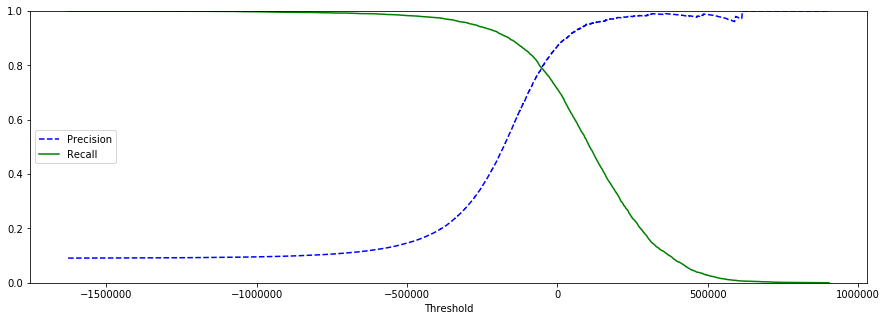

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plt.figure(figsize=[15, 5])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

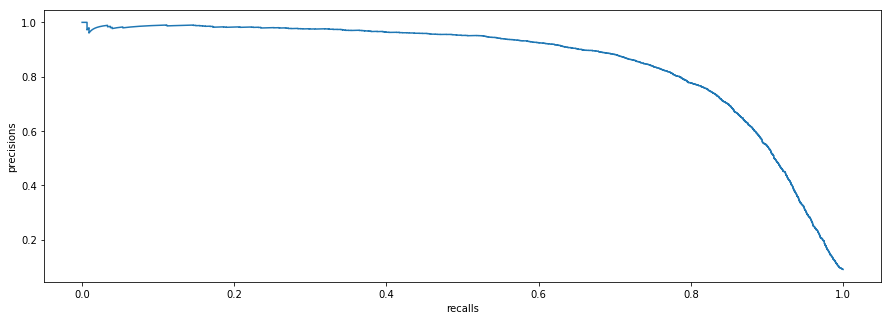

In [38]:
plt.figure(figsize=[15, 5])
plt.plot(recalls, precisions)
plt.ylabel("precisions")
plt.xlabel("recalls")
plt.show()